In [14]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from fastai.data.all import *
from fastai.vision.all import *
from duckduckgo_search import DDGS
from fastdownload import download_url

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

- Implement image search and download engine using DuckDuckGo library and `fastAi` image download function `

In [15]:
ddg = DDGS()
searches = 'forest','bird'
path = Path('bird_or_not')

def search_images(keywords):
  bird_images = ddg.images(
      keywords=keywords,
      max_results=1000,
  )
  return [img['image'] for img in bird_images]

- Loop throw defined parent categories, make a directory for each category and download the corresponding images. Finally resize the images for faster processing.

In [16]:
for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    resize_images(path/o, max_size=400, dest=path/o)

- Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [17]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

31

- fastai includes a replacement for Pytorch’s DataLoader which is largely API-compatible, and adds a lot of useful functionality and flexibility.
To train a model, we'll need DataLoaders, which is an object that contains a training set (the images used to create a model) and a validation set (the images used to check the accuracy of a model -- not used during training). In fastai we can create that easily using a DataBlock, and view sample images from it:

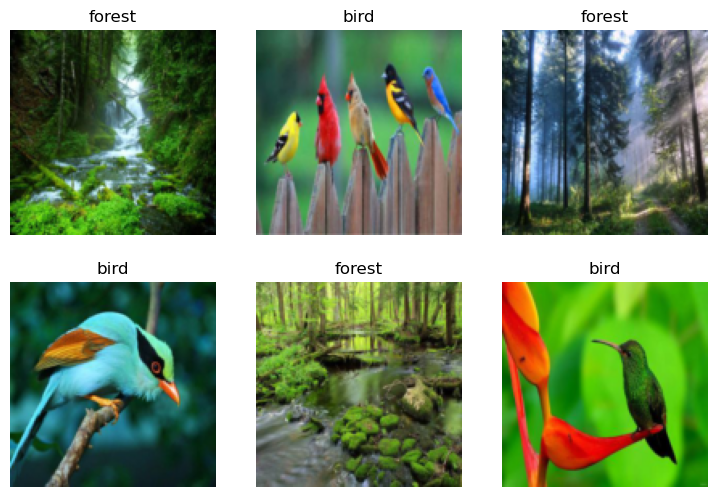

In [18]:
dls = DataBlock(
    # The inputs to our model are images, and the outputs are categories (in this case, "bird" or "forest").
    blocks=(ImageBlock, CategoryBlock),
    # To find all the inputs to our model, run the get_image_files function (which returns a list of all image files in a path).
    get_items=get_image_files,
    # Split the data into training and validation sets randomly, using 20% of the data for the validation set.
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    # The labels (y values) is the name of the parent of each file (i.e. the name of the folder they're in, which will be bird or forest).
    get_y=parent_label,
    # Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).
    item_tfms=[Resize(128, method=ResizeMethod.Squish)]
).dataloaders(path)

dls.show_batch(max_n=6)

Now we're ready to train our model. The fastest widely used computer vision model is resnet18. You can train this in a few minutes, even on a CPU! (On a GPU, it generally takes under 10 seconds...)

fastai comes with a helpful fine_tune() method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

In [ ]:
# Here we are passing the data `dls` then selecting the actual DeepLearning Model `resnet18` in this case. We can choose between
# a lot of PyTorch pre-defined models as well. ref: https://docs.fast.ai/vision.models.xresnet.html
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /Users/nami/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:17<00:00, 5.86MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,0.351520,0.308149,0.042904,00:06


epoch,train_loss,valid_loss,error_rate,time
0,0.086115,0.255081,0.049505,00:09
1,0.074592,0.197867,0.039604,00:08
2,0.057031,0.201004,0.046205,00:08


Let's see what our model thinks about a test image.

In [24]:
is_bird,_,probs = learn.predict(PILImage.create('bird.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")

This is a: bird.
Probability it's a bird: 0.9999
